In [1]:
import numpy as np
from clawpack import pyclaw
from clawpack import riemann
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow import keras
import os
from IPython.display import display, Math, Latex
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae

2022-10-15 10:19:52.448099: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


First we will work on creating numerical solutions to the following pde (scalar advection)

In [2]:
display(Math(r'q_{t} + uq_{x}=0'))

<IPython.core.display.Math object>

To do this we will use a python package for finite volume methods, Clawpack.<br>
We need to set up the functionality for creating a domain for Clawpack to run a simulation on.<br>
The following function returns a domain and a solver. <br>
The solver uses a 'SSP104' time integrator and a 5th order weno method.<br>
We have set up a maximum CFL of 2.5 and periodic boundary conditions.

In [3]:
def claw_domain(domain=[0,1], nx=128):
    riemann_solver = riemann.advection_1D
    solver = pyclaw.SharpClawSolver1D(riemann_solver)
    solver.weno_order = 5
    solver.time_integrator = 'SSP104'
    solver.kernel_language = 'Fortran'
    solver.bc_lower[0] = pyclaw.BC.periodic
    solver.bc_upper[0] = pyclaw.BC.periodic
    solver.cfl_max = 2.5
    x = pyclaw.Dimension(domain[0], domain[1], nx, name='x')
    return pyclaw.Domain(x), solver
test_domain, test_solver = claw_domain()
test_state = pyclaw.State(test_domain, test_solver.num_eqn)

For the initial conditions used during training and evaluation we will use the following functions

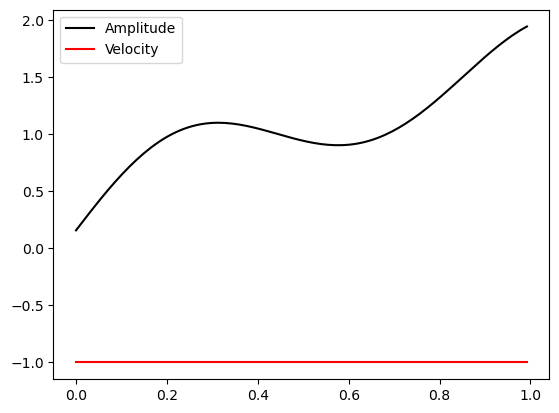

In [4]:
#This is the IC for the 'amplitude'
def qinit_train(state):
    # Initial Data parameters
    xc = state.grid.x.centers
    center = np.random.uniform(0, 1, (2,))
    freq = np.random.uniform(1, 4, (2,))
    height = np.random.uniform(.05, .15, (1,))
    state.q[0, :] = np.abs(np.sin(freq[0] * (xc - center[0])) + np.cos(freq[1] * (xc-center[1])) ** 2) + height
#This is the IC for velocity (a scalar)
def auxinit_train(state):
    state.problem_data['u'] = np.random.choice(a=[-1, 1])

#Printing out an example output
qinit_train(test_state)
auxinit_train(test_state)
x = np.arange(0, 1, 1/128)
plt.plot(x, test_state.q[0, :], color='black', label='Amplitude')
plt.plot(x, np.full((128,), test_state.problem_data['u']), color='red', label='Velocity')
plt.legend()
plt.show()

Now we will create the functions to generate the initial conditions that are used in testing. The first function for amplitude has two exponential profiles. The second is a rectangular initial condition.<br>
The first velocity function simply returns a velocity of 1. The second returns -1.

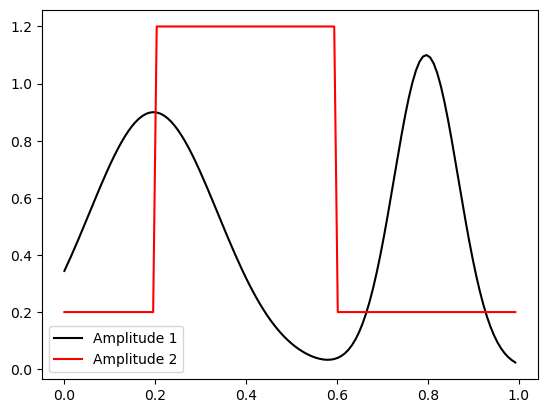

In [5]:
#This is the testing IC for amplitude that is comprised of two exponential profiles
def qinit_test_1(state):
    xc = state.grid.x.centers
    decay = [25, 100]
    center = [.2, .8]
    amplitude = [.9, 1.1]
    state.q[0, :] = amplitude[0] * np.exp(-decay[0] * (xc - center[0])**2) + amplitude[1] * np.exp(-decay[1] * (xc - center[1])**2)
#This is the rectangular testing IC for amplitude
def qinit_test_2(state):
    xc = state.grid.x.centers
    h1 = .2
    h2 = 1
    length = .4
    start = .2
    state.q[0, :] = h1 + h2 * (xc >= start) * (xc <= (start + length))
#This creates a velocity of +1
def auxinit_test_1(state):
    # Initilize petsc Structures for aux
    state.problem_data['u'] = 1
#This creates a velocity of -1
def auxinit_test_1(state):
    # Initilize petsc Structures for aux
    state.problem_data['u'] = -1

#Printing out both test ICs for amplitude
qinit_test_1(test_state)
plt.plot(x, test_state.q[0, :], color='black', label='Amplitude 1')
qinit_test_2(test_state)
plt.plot(x, test_state.q[0, :], color='red', label='Amplitude 2')
plt.legend()
plt.show()

Now we will create the function for creating the training data. You pass parameters for the reference dimension, the dimension that you want to downsample to, the number of steps and the final time of the simulation (determining dt for a single step on each initial condition), the number of training examples, and the directory where you'd like to store the data

In [6]:
def gen_train(ref_dimensions, dimensions, nsteps, tfinal, num_train, outdir):
    for i in range(num_train):
        domain, solver = claw_domain(domain=[0, 1], nx=ref_dimensions)
        state = pyclaw.State(domain, solver.num_eqn)
        auxinit_train(state)
        qinit_train(state)
        claw = pyclaw.Controller()
        claw.outdir = outdir + '/_output'
        claw.solution = pyclaw.Solution(state, domain)
        claw.solver = solver
        claw.num_output_times = 1
        claw.tfinal = tfinal / nsteps
        claw.keep_copy = True
        claw.run()
        inp = np.expand_dims(down_sample(claw.frames[0].q[0], dimensions=ref_dimensions, factor=8), axis=-1)
        out = np.expand_dims(down_sample(claw.frames[-1].q[0], dimensions=ref_dimensions, factor=8), axis=-1)
        u = np.full((dimensions, 1), claw.frames[0].problem_data['u'])
        np.save(outdir + '/training/ex_' + str(i) + '.npy', np.concatenate([inp, u, out], axis=-1))

The function for creating the validation data is almost identical

In [7]:
def gen_val(ref_dimensions, dimensions, nsteps, tfinal, num_val, outdir):
    for i in range(num_val):
        domain, solver = claw_domain(domain=[0, 1], nx=ref_dimensions)
        state = pyclaw.State(domain, solver.num_eqn)
        auxinit_train(state)
        qinit_train(state)
        claw = pyclaw.Controller()
        claw.outdir = outdir + '/_output'
        claw.solution = pyclaw.Solution(state, domain)
        claw.solver = solver
        claw.num_output_times = 1
        claw.tfinal = tfinal / nsteps
        claw.keep_copy = True
        claw.run()
        inp = np.expand_dims(down_sample(claw.frames[0].q[0], dimensions=ref_dimensions, factor=8), axis=-1)
        out = np.expand_dims(down_sample(claw.frames[-1].q[0], dimensions=ref_dimensions, factor=8), axis=-1)
        u = np.full((dimensions, 1), claw.frames[0].problem_data['u'])
        np.save(outdir + '/validation/ex_' + str(i) + '.npy', np.concatenate([inp, u, out], axis=-1))

The function for generating the test data is slightly different. We generate numerical solutions from 1/2 to 16 times the base resolution and downsample each by factors of 1 (no downsampling), 2, 4, and 8 to 1/2x, 1x, and 2x the base resolution (128 by default). The deep learning model weights are applied at resolutions of 1/2x, 1x, and 2x the base resolution (trained on 1x). At each of those resolutions the output of the deep learning model is compared to the numerical solutions at 1, 2, 4, and 8 times resolution that have been downsampled by that same factor.

In [8]:
def gen_test(dimensions, nsteps, tfinal, outdir):
    print('Done generating training and validation data, starting with the generation of simulations for test cases')
    for mult in [1/2, 1, 2, 4, 8, 16]:
        domain, solver = claw_domain(nx=int(dimensions * mult))
        state = pyclaw.State(domain, solver.num_eqn)

        auxinit_test_1(state)
        qinit_test_1(state)

        for i in range(nsteps):
            print(i, mult)
            claw = pyclaw.Controller()
            claw.outdir = outdir + '/_output'
            claw.solution = pyclaw.Solution(state, domain)
            claw.solver = solver
            claw.num_output_times = 1
            claw.tfinal = tfinal / nsteps
            claw.keep_copy = True

            claw.run()
            next_ = claw.frames[-1].q[0]
            last = claw.frames[0].q[0]

            if mult >= 1/2 and mult <= 4:
                np.save(outdir+'/testing/'+str(int(mult * dimensions)) + '->' + str(int(dimensions / 2)) + '_step:' + str(i) + '.npy', down_sample(last, dimensions * mult, int(mult * 2)))
            if mult >= 1 and mult <= 8:
                np.save(outdir+'/testing/' + str(int(mult * dimensions)) + '->' + str(int(dimensions)) + '_step:' + str(i) + '.npy', down_sample(last, dimensions * mult, int(mult)))
            if mult >= 2 and mult <= 16:
                np.save(outdir+'/testing/' + str(int(mult * dimensions)) + '->' + str(int(dimensions * 2)) + '_step:' + str(i) + '.npy', down_sample(last, dimensions * mult, int(mult / 2)))

            state = pyclaw.State(domain, solver.num_eqn)
            state.q[0, :] = next_
            auxinit_test_1(state)

Now we will create a simple wrapper function for gen_train, gen_val, and gen_test

In [9]:
def gen_data(outdir, dimensions=128, nsteps=128, tfinal=1.0, num_train=20000, num_val=5000):
    # generate 'num_train' training pairs
    # run training for model by taking 1 timestep of size tfinal/nsteps at 8x resolution for a numerical model
    # - 8x resolution is the reference solution
    ref_dimensions = 8 * dimensions
    gen_train(ref_dimensions, dimensions, nsteps, tfinal, num_train, outdir)
    gen_val(ref_dimensions, dimensions, nsteps, tfinal, num_val, outdir)
    gen_test(dimensions, nsteps, tfinal, outdir)
    # run evaluation for model at its original training resolution as well as at double and half the resolution

We will repeat the above except for Lax Wendroff solutions. We will contain everything necessary in a class.

In [ ]:
class LaxWendroff:
    def __init__(self, dx, dt, u='1', ic='exponential', x_l=0, x_r=1):
        self.dx = dx
        self.dt = dt
        self.nx = int((x_r - x_l) / dx)
        self.x_l = x_l
        self.x_r = x_r
        self.gen_ic(ic)
        self.gen_u(u)
    def gen_ic(self, ic):
        xc = np.arange(self.x_l, self.x_r, self.dx, dtype=np.float64)
        if ic == 'exponential':
            decay = [25, 100]
            center = [.2, .8]
            amplitude = [.9, 1.1]
            self.state = amplitude[0] * np.exp(-decay[0] * (xc - center[0])**2) + amplitude[1] * np.exp(-decay[1] * (xc - center[1])**2)
        elif ic == 'rectangular':
            h1 = .2
            h2 = 1
            length = .4
            start = .2
            self.state = h1 + h2 * (xc >= start) * (xc <= (start + length))
        elif ic == 'random':
            center = np.random.uniform(0, 1, (2,))
            freq = np.random.uniform(1, 4, (2,))
            height = np.random.uniform(.05, .15, (1,))
            self.state = np.abs(np.sin(freq[0] * (xc - center[0])) + np.cos(freq[1] * (xc - center[1])) ** 2) + height
    def gen_u(self, u):
        if u == '1':
            self.velocity = np.ones(self.nx)
        elif u == '-1':
            self.velocity = -np.ones(self.nx)
        elif u == 'random':
            self.velocity = np.random.choice(a=[-1, 1])
    def step(self):
        print(self.state.shape, '*****', self.velocity.shape)
        q = np.concatenate([[self.state[-1]], self.state, [self.state[0]]], axis=0)
        u = np.concatenate([[self.velocity[-1]], self.velocity, [self.velocity[0]]], axis=0)
        q_l = q[:-2]
        q_r = q[2:]
        u_l = u[:-2]
        u_r = u[2:]
        self.state = self.state - (self.dt / self.dx / 2) * (q_r * u_r - q_l * u_l) + (((self.dt/self.dt) ** 2) / 2) * (((u_r + self.velocity) / 2 * (q_r * u_r - self.state * self.velocity)) - ((q_l + self.velocity) / 2 * (self.velocity * self.state - q_l * u_l)))
        return self.state
    def run_sim(self, n_steps, save=False, outdir=''):
        if save == 'True':
            for i in range(n_steps):
                np.save(outdir +'/step_'+str(i)+'.npy', self.step())
        else:
            for i in range(n_steps):
                self.step()
    def gen_train(self, ref_dimensions, num_train, outdir):
        self.gen_ic('random')
        self.gen_u('random')
        inp = self.state
        for i in range(num_train):
            self.step()
            out = self.state
            np.save(outdir + '/training/ex_' + str(i) + '.npy', np.concatenate([np.expand_dims(down_sample(inp, dimensions=ref_dimensions, factor=8), axis=-1), self.velocity, np.expand_dims(down_sample(out, dimensions=ref_dimensions, factor=8), axis=-1)], axis=-1))
            inp = out
    def gen_val(self, ref_dimensions, num_val, outdir):
        self.gen_ic('random')
        self.gen_u('random')
        inp = self.state
        for i in range(num_val):
            self.step()
            out = self.state
            np.save(outdir + '/validation/ex_' + str(i) + '.npy', np.concatenate(
                [np.expand_dims(down_sample(inp, dimensions=ref_dimensions, factor=8), axis=-1), self.velocity,
                 np.expand_dims(down_sample(out, dimensions=ref_dimensions, factor=8), axis=-1)], axis=-1))
            inp = out
    def gen_test(self, outdir, nsteps, ic, u):
        dimensions = self.nx
        for mult in [1/2, 1, 2, 4, 8, 16]:
            self.dx /= mult
            self.nx = mult
            self.gen_ic(ic)
            self.gen_u(u)
            inp = self.state
            for i in range(nsteps):
                if mult >= 1 / 2 and mult <= 4:
                    np.save(outdir + '/testing/' + str(int(mult * dimensions)) + '->' + str(
                        int(dimensions / 2)) + '_step:' + str(i) + '.npy',
                            down_sample(inp, dimensions * mult, int(mult * 2)))
                if mult >= 1 and mult <= 8:
                    np.save(outdir + '/testing/' + str(int(mult * dimensions)) + '->' + str(
                        int(dimensions)) + '_step:' + str(i) + '.npy', down_sample(inp, dimensions * mult, int(mult)))
                if mult >= 2 and mult <= 16:
                    np.save(outdir + '/testing/' + str(int(mult * dimensions)) + '->' + str(
                        int(dimensions * 2)) + '_step:' + str(i) + '.npy',
                            down_sample(inp, dimensions * mult, int(mult / 2)))
                self.step()          
            self.dx *= mult
            self.nx /= mult

We can start on the deep learning models now. First we will define a Unet model. Padding for all models has been done with lambda layers that connect feature maps on the boundaries in a way consistent with periodic boundary conditions

In [10]:
def UNet(pretrained_weights=None, input_shape=(128, 2)):
    inputs = Input(input_shape)
    periodic_padd = Lambda(lambda b: tf.concat([tf.slice(b, [0, input_shape[0]-1, 0], [-1, -1, -1]), b, tf.slice(b, [0, 0, 0], [-1, 1, -1])], axis=1))
    conv1 = Conv1D(64, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd(BatchNormalization(axis=[1, 2])(inputs)))
    conv1 = Conv1D(64, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd(BatchNormalization(axis=[1, 2])(conv1)))
    pool1 = AveragePooling1D(pool_size=2)(conv1)
    periodic_padd = Lambda(lambda b: tf.concat(
        [tf.slice(b, [0, int(input_shape[0]/2) - 1, 0], [-1, -1, -1]), b, tf.slice(b, [0, 0, 0], [-1, 1, -1])], axis=1))
    conv2 = Conv1D(128, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd(BatchNormalization(axis=[1, 2])(pool1)))
    conv2 = Conv1D(128, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd(BatchNormalization(axis=[1, 2])(conv2)))
    pool2 = AveragePooling1D(pool_size=2)(conv2)
    periodic_padd = Lambda(lambda b: tf.concat(
        [tf.slice(b, [0, int(input_shape[0] / 4) - 1, 0], [-1, -1, -1]), b, tf.slice(b, [0, 0, 0], [-1, 1, -1])],
        axis=1))
    conv3 = Conv1D(256, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd(BatchNormalization(axis=[1, 2])(pool2)))
    conv3 = Conv1D(256, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd(BatchNormalization(axis=[1, 2])(conv3)))
    pool3 = AveragePooling1D(pool_size=2)(conv3)
    periodic_padd = Lambda(lambda b: tf.concat(
        [tf.slice(b, [0, int(input_shape[0] / 8) - 1, 0], [-1, -1, -1]), b, tf.slice(b, [0, 0, 0], [-1, 1, -1])],
        axis=1))
    conv4 = Conv1D(512, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd(BatchNormalization(axis=[1, 2])(pool3)))
    conv4 = Conv1D(512, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd(BatchNormalization(axis=[1, 2])(conv4)))
    pool4 = AveragePooling1D(pool_size=2)(conv4)
    periodic_padd = Lambda(lambda b: tf.concat(
        [tf.slice(b, [0, int(input_shape[0] / 16) - 1, 0], [-1, -1, -1]), b, tf.slice(b, [0, 0, 0], [-1, 1, -1])],
        axis=1))
    conv5 = Conv1D(1024, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd(BatchNormalization(axis=[1, 2])(pool4)))
    conv5 = Conv1D(1024, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd(BatchNormalization(axis=[1, 2])(conv5)))
    drop5 = Dropout(0.2)(conv5)
    periodic_padd_2 = Lambda(lambda b: tf.concat([b, tf.slice(b, [0, 0, 0], [-1, 1, -1])], axis=1))
    up6 = Conv1D(512, 2, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd_2(BatchNormalization(axis=[1, 2])(
        UpSampling1D(size=2)(drop5))))
    periodic_padd = Lambda(lambda b: tf.concat(
        [tf.slice(b, [0, int(input_shape[0] / 8) - 1, 0], [-1, -1, -1]), b, tf.slice(b, [0, 0, 0], [-1, 1, -1])],
        axis=1))
    merge6 = concatenate([conv4, up6], axis=-1)
    conv6 = Conv1D(512, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd(BatchNormalization(axis=[1, 2])(merge6)))
    conv6 = Conv1D(512, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd(BatchNormalization(axis=[1, 2])(conv6)))

    up7 = Conv1D(256, 2, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd_2(BatchNormalization(axis=[1, 2])(
        UpSampling1D(size=2)(conv6))))
    periodic_padd = Lambda(lambda b: tf.concat(
        [tf.slice(b, [0, int(input_shape[0] / 4) - 1, 0], [-1, -1, -1]), b, tf.slice(b, [0, 0, 0], [-1, 1, -1])],
        axis=1))
    merge7 = concatenate([conv3, up7], axis=-1)
    conv7 = Conv1D(256, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd(BatchNormalization(axis=[1, 2])(merge7)))
    conv7 = Conv1D(256, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd(BatchNormalization(axis=[1, 2])(conv7)))

    up8 = Conv1D(128, 2, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd_2(BatchNormalization(axis=[1, 2])(
        UpSampling1D(size=2)(conv7))))
    periodic_padd = Lambda(lambda b: tf.concat(
        [tf.slice(b, [0, int(input_shape[0] / 2) - 1, 0], [-1, -1, -1]), b, tf.slice(b, [0, 0, 0], [-1, 1, -1])],
        axis=1))
    merge8 = concatenate([conv2, up8], axis=-1)
    conv8 = Conv1D(128, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd(BatchNormalization(axis=[1, 2])(merge8)))
    conv8 = Conv1D(128, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd(BatchNormalization(axis=[1, 2])(conv8)))

    up9 = Conv1D(64, 2, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd_2(BatchNormalization(axis=[1, 2])(
        UpSampling1D(size=2)(conv8))))
    periodic_padd = Lambda(lambda b: tf.concat(
        [tf.slice(b, [0, input_shape[0] - 1, 0], [-1, -1, -1]), b, tf.slice(b, [0, 0, 0], [-1, 1, -1])],
        axis=1))
    merge9 = concatenate([conv1, up9], axis=-1)
    conv9 = Conv1D(48, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd(BatchNormalization(axis=[1, 2])(merge9)))
    conv9 = Conv1D(16, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd(BatchNormalization(axis=[1, 2])(conv9)))
    out = Conv1D(1, 1, activation='tanh', kernel_initializer='he_normal')(conv9)
    model = Model(inputs=inputs, outputs=out, name='UNet_1')

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='mae', metrics=['mae'])

    print(model.summary())

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

Next we will give a second UNet where the velocity and amplitude input fields are multiplied together

In [11]:
def UNet2(pretrained_weights=None, input_shape=(128, 2)):
    inputs = Input(input_shape)
    input1 = Lambda(lambda b: tf.slice(b, [0, 0, 0], [-1, -1, 1]))(inputs)
    velocities = Lambda(lambda b: tf.slice(b, [0, 0, 1], [-1, -1, -1]))(inputs)
    v_times_in = multiply([input1, velocities])
    periodic_padd = Lambda(lambda b: tf.concat([tf.slice(b, [0, input_shape[0]-1, 0], [-1, -1, -1]), b, tf.slice(b, [0, 0, 0], [-1, 1, -1])], axis=1))
    conv1 = Conv1D(64, 3, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd(v_times_in))
    conv1 = Conv1D(64, 3, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd(conv1))
    pool1 = AveragePooling1D(pool_size=2)(conv1)
    periodic_padd = Lambda(lambda b: tf.concat(
        [tf.slice(b, [0, int(input_shape[0]/2) - 1, 0], [-1, -1, -1]), b, tf.slice(b, [0, 0, 0], [-1, 1, -1])], axis=1))
    conv2 = Conv1D(128, 3, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd(BatchNormalization(axis=[1, 2])(pool1)))
    conv2 = Conv1D(128, 3, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd(BatchNormalization(axis=[1, 2])(conv2)))
    pool2 = AveragePooling1D(pool_size=2)(conv2)
    periodic_padd = Lambda(lambda b: tf.concat(
        [tf.slice(b, [0, int(input_shape[0] / 4) - 1, 0], [-1, -1, -1]), b, tf.slice(b, [0, 0, 0], [-1, 1, -1])],
        axis=1))
    conv3 = Conv1D(256, 3, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd(BatchNormalization(axis=[1, 2])(pool2)))
    conv3 = Conv1D(256, 3, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd(BatchNormalization(axis=[1, 2])(conv3)))
    pool3 = AveragePooling1D(pool_size=2)(conv3)
    periodic_padd = Lambda(lambda b: tf.concat(
        [tf.slice(b, [0, int(input_shape[0] / 8) - 1, 0], [-1, -1, -1]), b, tf.slice(b, [0, 0, 0], [-1, 1, -1])],
        axis=1))
    conv4 = Conv1D(512, 3, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd(BatchNormalization(axis=[1, 2])(pool3)))
    conv4 = Conv1D(512, 3, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd(BatchNormalization(axis=[1, 2])(conv4)))
    pool4 = AveragePooling1D(pool_size=2)(conv4)
    periodic_padd = Lambda(lambda b: tf.concat(
        [tf.slice(b, [0, int(input_shape[0] / 16) - 1, 0], [-1, -1, -1]), b, tf.slice(b, [0, 0, 0], [-1, 1, -1])],
        axis=1))
    conv5 = Conv1D(1024, 3, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd(BatchNormalization(axis=[1, 2])(pool4)))
    conv5 = Conv1D(1024, 3, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd(BatchNormalization(axis=[1, 2])(conv5)))
    drop5 = Dropout(0.2)(conv5)
    periodic_padd_2 = Lambda(lambda b: tf.concat([b, tf.slice(b, [0, 0, 0], [-1, 1, -1])], axis=1))
    up6 = Conv1D(512, 2, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd_2(
        UpSampling1D(size=2)(BatchNormalization(axis=[1, 2])(drop5))))
    periodic_padd = Lambda(lambda b: tf.concat(
        [tf.slice(b, [0, int(input_shape[0] / 8) - 1, 0], [-1, -1, -1]), b, tf.slice(b, [0, 0, 0], [-1, 1, -1])],
        axis=1))
    merge6 = concatenate([conv4, up6], axis=-1)
    conv6 = Conv1D(512, 3, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd(BatchNormalization(axis=[1, 2])(merge6)))
    conv6 = Conv1D(512, 3, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd(BatchNormalization(axis=[1, 2])(conv6)))

    up7 = Conv1D(256, 2, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd_2(BatchNormalization(axis=[1, 2])(
        UpSampling1D(size=2)(conv6))))
    periodic_padd = Lambda(lambda b: tf.concat(
        [tf.slice(b, [0, int(input_shape[0] / 4) - 1, 0], [-1, -1, -1]), b, tf.slice(b, [0, 0, 0], [-1, 1, -1])],
        axis=1))
    merge7 = concatenate([conv3, up7], axis=-1)
    conv7 = Conv1D(256, 3, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd(BatchNormalization(axis=[1, 2])(merge7)))
    conv7 = Conv1D(256, 3, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd(BatchNormalization(axis=[1, 2])(conv7)))

    up8 = Conv1D(128, 2, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd_2(BatchNormalization(axis=[1, 2])(
        UpSampling1D(size=2)(conv7))))
    periodic_padd = Lambda(lambda b: tf.concat(
        [tf.slice(b, [0, int(input_shape[0] / 2) - 1, 0], [-1, -1, -1]), b, tf.slice(b, [0, 0, 0], [-1, 1, -1])],
        axis=1))
    merge8 = concatenate([conv2, up8], axis=-1)
    conv8 = Conv1D(128, 3, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd(BatchNormalization(axis=[1, 2])(merge8)))
    conv8 = Conv1D(128, 3, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd(BatchNormalization(axis=[1, 2])(conv8)))

    up9 = Conv1D(64, 2, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd_2(BatchNormalization(axis=[1, 2])(
        UpSampling1D(size=2)(conv8))))
    periodic_padd = Lambda(lambda b: tf.concat(
        [tf.slice(b, [0, input_shape[0] - 1, 0], [-1, -1, -1]), b, tf.slice(b, [0, 0, 0], [-1, 1, -1])],
        axis=1))
    merge9 = concatenate([conv1, up9], axis=-1)
    conv9 = Conv1D(48, 3, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd(BatchNormalization(axis=[1, 2])(merge9)))
    conv9 = Conv1D(16, 3, activation='tanh', padding='valid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001))(periodic_padd(BatchNormalization(axis=[1, 2])(conv9)))
    out = Conv1D(1, 1, kernel_initializer='he_normal')(conv9)
    model = Model(inputs=inputs, outputs=out, name='UNet_1')

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='mae', metrics=['mae'])

    print(model.summary())

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

We will also create a simple CNN model and a more complex version where velocity and amplitude are being multiplied. There is also a helper function for the periodic padding

In [12]:
def periodic_padd_3_128(x):
    return tf.tile(x, [1, 3, 1])[:, 127:257, :]

def CNN(pretrained_weights=None, input_shape=(128, 2)):
    inputs = Input(input_shape)
    bn1 = BatchNormalization(axis=[1, 2])(inputs)
    conv1 = Conv1D(2048, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd_3_128(bn1))
    bn2 = BatchNormalization(axis=[1, 2])(conv1)
    conv2 = Conv1D(1024, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd_3_128(bn2))
    bn3 = BatchNormalization(axis=[1, 2])(conv2)
    conv3 = Conv1D(256, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd_3_128(bn3))
    bn4 = BatchNormalization(axis=[1, 2])(conv3)
    conv4 = Conv1D(64, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd_3_128(bn4))
    bn5 = BatchNormalization(axis=[1, 2])(conv4)
    conv5 = Conv1D(1, 3, activation='tanh', padding='valid', kernel_initializer='he_normal')(periodic_padd_3_128(bn5))
    out = BatchNormalization(axis=[1, 2])(conv5)
    model = Model(inputs=inputs, outputs=out, name='Unet_5')

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='mae', metrics=['mae'])

    print(model.summary())

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model


def CNN2(pretrained_weights=None, input_shape=(128, 2)):
    inputs = Input(input_shape)
    input1 = Lambda(lambda b: tf.slice(b, [0, 0, 0], [-1, -1, 1]))(inputs)
    velocities = Lambda(lambda b: tf.slice(b, [0, 0, 1], [-1, -1, -1]))(inputs)
    conv1 = Conv1D(2048, 3, activation='tanh', padding='valid', use_bias=False, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001), kernel_initializer='he_uniform')(periodic_padd_3_128(input1))
    conv2 = Conv1D(2048, 3, activation='tanh', padding='valid', use_bias=False, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001), kernel_initializer='he_uniform')(periodic_padd_3_128(velocities))
    v_times_in = multiply([conv1, conv2])
    conv3 = Conv1D(1024, 3, activation='tanh', use_bias=False, padding='valid', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001), kernel_initializer='he_uniform')(periodic_padd_3_128(v_times_in))
    conv4 = Conv1D(256, 3, activation='tanh', use_bias=False, padding='valid', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001), kernel_initializer='he_uniform')(periodic_padd_3_128(conv3))
    conv5 = Conv1D(64, 3, activation='tanh', use_bias=False, padding='valid',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001), kernel_initializer='he_uniform')(periodic_padd_3_128(conv4))
    out = Conv1D(1, 1, use_bias=False, activation='tanh', padding='valid', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001), kernel_initializer='he_uniform')(conv5)
    model = Model(inputs=inputs, outputs=out, name='Unet_5')

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1), loss='mae', metrics=['mse'])

    print(model.summary())

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

Now that we have created the deep learning models, we will define the data generator necessary to read in the data we created using Clawpack batch by batch. <br>
The velocities are divided by the current grid size to (hopefully) allow weights to be applicable to grid sizes different than what was used in training. <br>
No statistical normalization of velocities or amplitude is done by default. <br>
To normalize all the data at once, use the function under the generator. <br>
To normalize a batch at a time you can simply normalize x,y before returning them in '__Data_generation()

In [13]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data_dir, list_IDs, dt=1/128, batch_size=32, dim=128, shuffle=True, training=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.dt = dt
        self.on_epoch_end()
        if training == True:
            self.dir = data_dir+'/training/'
        else:
            self.dir = data_dir+'/validation/'

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        x = np.empty((self.batch_size, self.dim, 2))
        y = np.empty((self.batch_size, self.dim, 1))
        for i, ID in enumerate(list_IDs_temp):
            data = np.load(self.dir + 'ex_'+str(ID)+'.npy')
            # I am dividing by the dimension so get velocities that are scaled to the current grid
            data[:, 1] = data[:, 1] * self.dim * self.dt
            x[i] = data[:, :-1]
            y[i] = data[:, [-1]] - data[:, [0]]
        return x, y
def normalize(num_train, num_val, train_dir, val_dir):
    mean_train = 0
    std_train = 0
    mean_val = 0
    std_val = 0
    for i in range(num_train):
         mean_train = mean_train + np.load(train_dir + 'ex_'+str(i)+'.npy')
    mean_train = mean_train / num_train
    for i in range(num_train):
         std_train = std_train + (np.load(train_dir + 'ex_'+str(i)+'.npy') - mean_train) ** 2
    std_train = np.sqrt(std_train / num_train)
    for i in range(num_train):
        data = (np.load(train_dir + 'ex_'+str(i)+'.npy') - mean_train) / std_train
        np.save(train_dir + 'ex_'+str(i)+'.npy', data)
    for i in range(num_val):
         mean_val = mean_val + np.load(val_dir + 'ex_'+str(i)+'.npy')
    mean_val = mean_val / num_val
    for i in range(num_val):
         std_val = std_val + (np.load(val_dir + 'ex_'+str(i)+'.npy') - mean_val) ** 2
    std_val = np.sqrt(std_val / num_val)
    for i in range(num_val):
        data = (np.load(val_dir + 'ex_'+str(i)+'.npy') - mean_val) / std_val
        np.save(val_dir + 'ex_'+str(i)+'.npy', data)

Now that we have created the functionality that we need we can generate the data and train and evaluate the models. This is where you can set all of your parameters for the problem. num_train is number of training examples (each a single time step). num_val is the number of validation examples (also 1 time step). The batch_size is the number of training examples used in each batch fed into the deep learning model.

In [14]:
num_train = 20000
num_val = 5000
epochs = 1
batch_size = 32
dt = 1/128
tfinal = 1.0
data_dir = '/home/jacob/PycharmProjects/1D_DL_Advection_Emulation/Claw_Data/Scalar_Advect'
model_dir = '/home/jacob/PycharmProjects/1D_DL_Advection_Emulation/DL_Models/'

Comment the next cell out if you don't need the data anymore

In [15]:
#gen_data(data_dir, dimensions=128, nsteps=int(tfinal/dt), tfinal=tfinal, num_train=num_train, num_val=num_val)

Here is the function that trains our models. It returns a list of the returned models after saving a copy to the model_dir that you select. 'labels' is the variable used to control how the models are saved

In [16]:
def f_train(models, labels, num_train, num_val, dt, batch_size, data_dir, model_dir):
    model_builds = []

    for i, m in enumerate(models):
        model_build = m()
        train_generator = DataGenerator(data_dir, np.arange(num_train)[1:], dt=dt, dim=128, batch_size=batch_size, training=True)
        val_generator = DataGenerator(data_dir, np.arange(num_val), dt=dt, dim=128, batch_size=batch_size, training=False)
        print(labels[i])
        callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
                     EarlyStopping(monitor='val_loss', patience=10),
                     TensorBoard(log_dir=model_dir + labels[i] + '_logs', update_freq='epoch')]
        # Train model on dataset
        print('training')
        model_build.fit_generator(generator=train_generator, validation_data=val_generator, epochs=epochs, callbacks=callbacks)
        print('saving')
        model_build.save(model_dir + labels[i])
        model_builds.append(model_build)
    return model_builds

After the models have been trained they can be evaluated with the following function. You pass the model_builds as input to the function.

In [17]:
def f_eval(model_builds, models, num_train, num_val, batch_size, data_dir, dt, tfinal, resolutions=[32, 64, 128], plot_steps = [0, 1, 2, 3, 4, 5]):
    # we will collect errors for each model as well as errors for the numerical method at 1x, 2x->1x, and 4x->1x resolution
    #for res in [64, 128, 256]. Choose [128] to only test with the same resolution used for training
    nsteps = int(tfinal/dt)
    for res in resolutions:
        print('resolution is: ', res)
        #Normalize the velocities here
        velocity_u = np.full((res,), 1) * res * dt
        errors = np.zeros((nsteps-1, len(models) + 4))
        saved_solns = np.zeros((len(plot_steps), len(models) + 1, res))
        last_soln = np.zeros((res,))
        ref_soln = np.zeros((res,))
        for i, m1 in enumerate(model_builds):
            # m1 = model
            for step in range(nsteps-1):
                if step == 0:
                    data_inp = np.load(
                        data_dir + '/testing/' + str(int(res * 8)) + '->' + str(res) + '_step:' + str(0) + '.npy')
                    print('inp shape is: ', data_inp.shape)
                else:
                    data_inp = last_soln
                ref_soln = np.load(
                    data_dir + '/testing/' + str(int(res * 8)) + '->' + str(res) + '_step:' + str(step + 1) + '.npy')
                last_soln = m1(
                    np.concatenate([np.expand_dims(data_inp, axis=(0, -1)), np.expand_dims(velocity_u, axis=(0, -1))],
                                   axis=-1))[0, :, 0] + data_inp
                if step in plot_steps:
                    saved_solns[plot_steps.index(step), -1] = ref_soln
                    saved_solns[plot_steps.index(step), i] = last_soln
                    errors[step, i] = mae(last_soln, ref_soln)
                else:
                    errors[step, i] = mae(ref_soln, last_soln)
                errors[step, -1] = mae(np.load(
                    data_dir + '/testing/' + str(int(res * 4)) + '->' + str(res) + '_step:' + str(step + 1) + '.npy'),
                                       ref_soln)
                errors[step, -2] = mae(np.load(
                    ddata_dir + '/testing/' + str(int(res * 2)) + '->' + str(res) + '_step:' + str(step + 1) + '.npy'),
                                       ref_soln)
                errors[step, -3] = mae(np.load(
                    data_dir + '/testing/' + str(int(res * 1)) + '->' + str(res) + '_step:' + str(step + 1) + '.npy'),
                                       ref_soln)
                errors[step, -4] = np.mean(np.abs(ref_soln))
        x = np.arange(nsteps-1) + 1
        for i in range(len(models)):
            plt.plot(x, errors[:, i], label=labels[i], color='red')
        plt.plot(x, errors[:, -4], label='Avg abs soln value, res=' + str(res), color='black')
        plt.plot(x, errors[:, -3], label='1x res FV soln', color='blue')
        plt.plot(x, errors[:, -2], label='2x res FV soln', color='green')
        plt.plot(x, errors[:, -1], label='4x res FV soln', color='orange')
        plt.legend()
        plt.title(str(res) + '-res MAEs')
        plt.xlabel('Simulation Step')
        plt.ylabel('MAE')
        plt.show()
        xlist = np.linspace(0, 1, res)
        for j in range(len(plot_steps)):
            for z in range(len(models)):
                fig, ax = plt.subplots(1, 1)
                ax.plot(xlist, saved_solns[j, z])
                ax.set_title(str(res) + '-res Solution, ' + str(z) + 'th model, ' + 'step=' + str(plot_steps[j] + 1))
                ax.set_xlabel('Location')
                ax.set_ylabel('y axis')
                plt.show()
            fig, ax = plt.subplots(1, 1)
            ax.plot(xlist, saved_solns[j, -1])
            ax.set_title(str(res) + '-res Ref Solution, ' + 'step=' + str(plot_steps[j] + 1))
            ax.set_xlabel('Location')
            ax.set_ylabel('y axis')
            plt.show()

Now we finally train and evaluate the models we want to work with

In [ ]:
#You can use a subset of the models to work with a smaller group at a time
#models = [UNet, UNet2, CNN, CNN2]
#labels = ['UNet1', 'UNet2', 'CNN1', 'CNN2']
models = [UNet]
labels = ['UNet1']
model_builds = f_train(models, labels, num_train, num_val, dt, batch_size, data_dir, model_dir)

In [ ]:
f_eval(model_builds, models, num_train, num_val, batch_size, data_dir, dt, tfinal, [128], [0, 1, 2, 3, 4, 5])